Estimadores lineales para regresión en TensorFlow --- 15:12 min
===

Última modificación: Agosto 6, 2021 | [YouTube](https://youtu.be/wb0fyfjyoM8)

TensorFlow no esta limitado a modelos de aprendizaje profundo y también incluye modelos lineales y árboles. Muchos de estos modelos son accesibles usando estimadores, que son modelos con capas ya configuradas para los cuales solo es necesario usar las funciones de entrenamiento y pronostico. En esta lección se presentan los elementos básicos para el uso de estimadores y se ejemplifican con la construcción de un estimador lineal.

## Importación de librerías

In [1]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import tensorflow as tf

print(tf.__version__)

#
# Establece el nivel de reporte en
# pantalla de TensorFlow
#
import logging

logger = tf.get_logger().setLevel(logging.ERROR)

2.5.0


## Carga y configuración del dataset

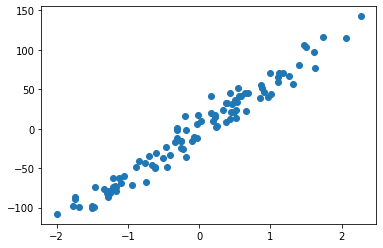

In [2]:
#
#  Datos del problema propuesto
#
from sklearn.datasets import make_regression

X, d = make_regression(
    n_samples=100,  
    n_features=1,  
    n_informative=1,  
    bias=0.0,             # intercepto
    effective_rank=None,  # numero de vectores singulares para explicar los datos
    tail_strength=0.9,    # ? importancia relativa de las colas 
    noise=12.0,  
    shuffle=False,  
    coef=False,  
    random_state=12136,
)

plt.scatter(X, d);

## Columnas de características

Para columnas categoricas cuyos valores conocidos:

```python
eye_color = tf.feature_column.categorical_column_with_vocabulary_list(
    "eye_color", 
    vocabulary_list=["blue", 
                     "brown", 
                     "green"])
```

Para columnas categoricas para las que no se conocen todos los valores posibles:

```python
education = tf.feature_column.categorical_column_with_hash_bucket(
    "education", 
    hash_bucket_size=1000)
```

Para combinaciones:

```python
sport_x_city = tf.feature_column.crossed_column(
    ["sport", "city"], 
    hash_bucket_size=int(1e4))
```

Bucketization:

```python
age_buckets = tf.feature_column.bucketized_column(
    age, 
    boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
```

In [3]:
#
#  Indica que la columna `x` es numérica
#
column = tf.feature_column.numeric_column("x")
column

NumericColumn(key='x', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)

## Funciones de entrada de datos para los estimadores

In [4]:
#
#  Función de entrada para el estimador.
#
#    Debe retornar una tupla con (entradas, salida).
#    Note que features es un diccionario que contine
#    una paraja clave-valor por cada variable
#    independiente
#
def input_fn_train():
    features = {"x": np.array(X)}
    labels = d
    return features, labels


#
#  Esta función es igual que la anterior, pero
#  retorna únicamente el data.frame de variables
#  independientes
#
def input_fn_predict():
    features = {"x": X}
    return features

## Baseline regressor

In [5]:
#
#  Construye el estimador base, cuya salida es
#  una constante.
#
regressor = tf.estimator.BaselineRegressor()

#
#  Entrenamiento.
#
regressor.train(
    # función de entrada
    input_fn=input_fn_train,
    # número de iteraciones (optimización)
    steps=100,
)

#
#  Pronostica para nuevos valores. En este
#  caso se usa la misma función de entrada que
#  para el entrenamiento.
#
results = regressor.predict(input_fn=input_fn_predict)

#
# Results es un iterator que retorna un diccionario.
#
next(results).keys()

dict_keys(['predictions'])


Test set loss: 3448.505



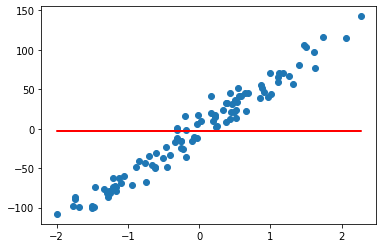

In [6]:
forecasts = []

for i, value in zip(X, results):

    #
    #  Se almacenan los valores pronosticodos en una lista
    #  para poder graficarlos
    #
    forecasts += value["predictions"].tolist()

#
#  Grafica los puntos de la muestra de datos
#
plt.plot(X, d, "o")

#
#  Grafica los pronósticos del modelo
#
plt.plot(X, forecasts, "-", color="red")

#
#  Imprime los estadísticos de error.
#
result = regressor.evaluate(
    input_fn=input_fn_train, 
    steps=1)

print("\nTest set loss: {loss:0.3f}\n".format(**result))

## Linear Regressor


Test set loss: 129.973



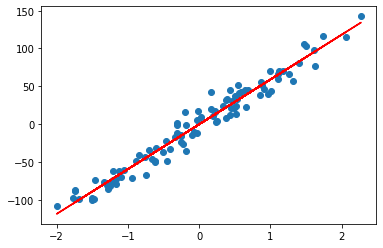

In [7]:
#
#  Construye el estimador lineal, cuya salida es
#  el resultado de la regresión lineal entre
#  x y y.
#
regressor = tf.estimator.LinearRegressor(
    feature_columns=[column], 
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.2),
)

#
#  Entrenamiento
#
regressor.train(
    input_fn=input_fn_train, 
    steps=500,
)

#
#  Pronostica para nuevos valores. En este
#  caso se usa la misma función de entrada que
#  para el entrenamiento.
#
results = regressor.predict(
    input_fn=input_fn_predict
)


forecasts = []

#
# No se puede iterar unicamente sobre results
# ya que es un generador y resulta en un 
# ciclo infinito
#
for i, value in zip(X, results):
    
    #
    #  Se almacenan los valores pronosticados
    #  en una lista para poder graficarlos
    #
    forecasts += value["predictions"].tolist()


#
#  Grafica los puntos de la muestra de datos
#
plt.plot(X, d, "o")

#
#  Grafica los pronósticos del modelo
#
plt.plot(X, forecasts, "-", color="red")

#
#  Imprime los estadísticos de error.
#
result = regressor.evaluate(input_fn=input_fn_train, steps=1)
print("\nTest set loss: {loss:0.3f}\n".format(**result))